<a href="https://colab.research.google.com/github/coraldx5/generativeai_intro_book/blob/master/chap07_mnist_digit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第7章：画像分類問題を解いてみよう
- 手書きの数字を1~9に分類するモデルを作成します

- 本Notebookのゴール感
  - コードを動かしながら画像解析に対する理解を深める

## GPUが使用可能であることを確認
- 手動で設定する場合には「ランタイム」メニュー→「ランタイムのタイプを変更」→「ハードウェア アクセラレータ」をGPU（T4 GPU、など）に設定→「保存」ボタンを押下

In [1]:
!nvidia-smi  # ←GPUが使用可能であることを確認

Wed Jul 24 01:57:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## ライブラリのインポート

In [2]:
# TensorFlowライブラリをtfという別名でインポートします
import tensorflow as tf

# Kerasのインポート
import keras
from keras import layers
from keras import initializers

# ネットワーク（モデル）を構築するための「部品」をインポートします
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Flatten, Dense

# モデルの構造を可視化するためのライブラリをインポートします
from tensorflow.keras.utils import plot_model

# グラフや画像を描画するためのライブラリをインポートします
from IPython.display import Image, display
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
# 結果の再現性を担保するために乱数シードを固定
keras.utils.set_random_seed(821)
tf.config.experimental.enable_op_determinism()

## 学習に使うデータの準備

### データの準備（[MNISTデータ](https://ja.wikipedia.org/wiki/MNIST%E3%83%87%E3%83%BC%E3%82%BF%E3%83%99%E3%83%BC%E3%82%B9)のダウンロード）


- tf.keras.datasets.~を使うことで、[すでに公開されているデータセット](https://keras.io/api/datasets/)を取得することが可能です

- 今回用いる数字データセット（MNIST digits classification dataset）の詳細は[こちら](https://keras.io/api/datasets/mnist/)  

11490434/11490434 [==============================] - 0s 0us/step
学習用画像の形状:  (60000, 28, 28)
学習用ラベルの形状:  (60000,)
検証用画像の形状:  (10000, 28, 28)
検証用ラベルの形状:  (10000,)


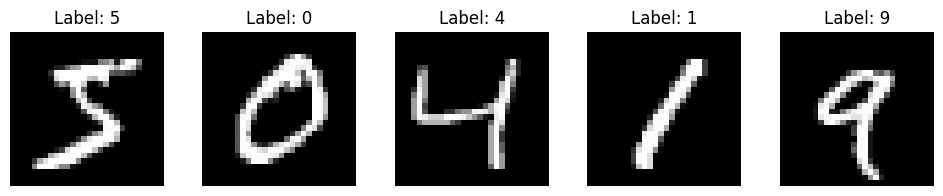

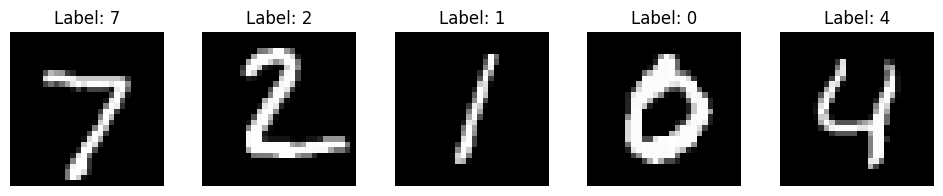

In [3]:
# MNISTデータセットの読み込み
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# データの正規化
x_train = x_train / 255.0
x_test = x_test / 255.0

# データの確認
print("学習用画像の形状: ", x_train.shape)
print("学習用ラベルの形状: ", y_train.shape)
print("検証用画像の形状: ", x_test.shape)
print("検証用ラベルの形状: ", y_test.shape)

# データの可視化
def plot_sample_images(images, labels, num_samples):
    plt.figure(figsize=(12, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

# 学習用データから5個のサンプルを表示
plot_sample_images(x_train, y_train, num_samples=5)
# 検証用データから5個のサンプルを表示
plot_sample_images(x_test, y_test, num_samples=5)

### 学習用/検証用データに含まれる各ラベルの枚数を確認

In [4]:
# 各ラベルの数を計算する関数
def count_labels(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

# 学習用データと検証用データのラベル数を計算
train_label_counts = count_labels(y_train)
test_label_counts = count_labels(y_test)

# データフレームにまとめる
df = pd.DataFrame({
    'ラベル': list(train_label_counts.keys()),
    '学習用データの数': list(train_label_counts.values()),
    '検証用データの数': [test_label_counts.get(label, 0) for label in train_label_counts.keys()]
})

# データフレームを表示
df

,ラベル,学習用データの数,検証用データの数
0,0,5923,980
1,1,6742,1135
2,2,5958,1032
3,3,6131,1010
4,4,5842,982
5,5,5421,892
6,6,5918,958
7,7,6265,1028
8,8,5851,974
9,9,5949,1009


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 29.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=a22c24fae35fd0febf78c67c413ba27e1d1ea93ede5eeee006fa14b0145d6e19
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


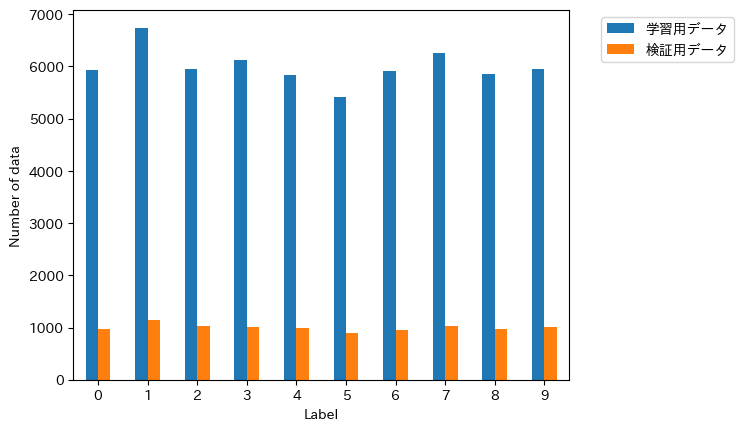

In [5]:
# @title ## 参考：学習用/検証用データに含まれる各ラベルの枚数をグラフで確認
!pip install japanize-matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib
df.plot.bar(x='ラベル', y=['学習用データの数','検証用データの数'], legend=False)
plt.xlabel('Label')
plt.ylabel('Number of data')
plt.xticks(rotation=0)
plt.legend(['学習用データ', '検証用データ'], bbox_to_anchor=(1.05, 1), loc='upper left')  # 凡例を右側に配置
plt.show()

In [1]:
'''
参考：このコードセルの内容を理解する必要はありません
'''
# @title ## 学習曲線を描画する関数の定義
# @markdown - 学習曲線をグラフ化する関数`plot_learning_curve`を定義するコードセルです

# @markdown - コード内容を理解する必要はありませんが実行は必要です

# 学習曲線を描画する関数の定義
def plot_learning_curve(history):
    # 学習用データと検証用データの正解率を取得
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    # 学習用データと検証用データの損失を取得
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # エポック数の範囲を設定
    epochs = range(1, len(acc) + 1)

    # 正解率をプロット
    plt.figure(figsize=(12, 4))  # グラフのサイズを設定
    plt.subplot(1, 2, 1)  # 2つのサブプロットのうち1つ目
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')  # 学習用データの正解率をプロット
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')  # 検証用データの正解率をプロット
    plt.title('Training and validation accuracy')  # グラフのタイトル
    plt.xlabel('Epochs')  # X軸のラベル
    plt.ylabel('Accuracy')  # Y軸のラベル
    plt.legend()  # 凡例を表示

    # 損失をプロット
    plt.subplot(1, 2, 2)  # 2つのサブプロットのうち2つ目
    plt.plot(epochs, loss, 'bo-', label='Training loss')  # 学習用データの損失をプロット
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')  # 検証用データ損失をプロット
    plt.title('Training and validation loss')  # グラフのタイトル
    plt.xlabel('Epochs')  # X軸のラベル
    plt.ylabel('Loss')  # Y軸のラベル
    plt.legend()  # 凡例を表示

    plt.show()  # グラフを表示

## もっとも単純なモデルを作ってみよう

In [2]:
# モデルの定義
model01 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(10, activation='softmax')
], name='model01')

# モデルのサマリーを表示
model01.summary()

# モデルを可視化して画像を出力
plot_model(model01, to_file='model01.png', show_shapes=True, show_layer_names=False)
# 画像を表示
display(Image(filename='model01.png'))

NameError: name 'Sequential' is not defined

### モデルのコンパイルと学習

Epoch 1/5
1875/1875 [==============================] - 20s 8ms/step - loss: 0.4671 - accuracy: 0.8783 - val_loss: 0.3058 - val_accuracy: 0.9156
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3033 - accuracy: 0.9153 - val_loss: 0.2830 - val_accuracy: 0.9219
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2830 - accuracy: 0.9213 - val_loss: 0.2740 - val_accuracy: 0.9236
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2728 - accuracy: 0.9238 - val_loss: 0.2698 - val_accuracy: 0.9259
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2669 - accuracy: 0.9257 - val_loss: 0.2659 - val_accuracy: 0.9261


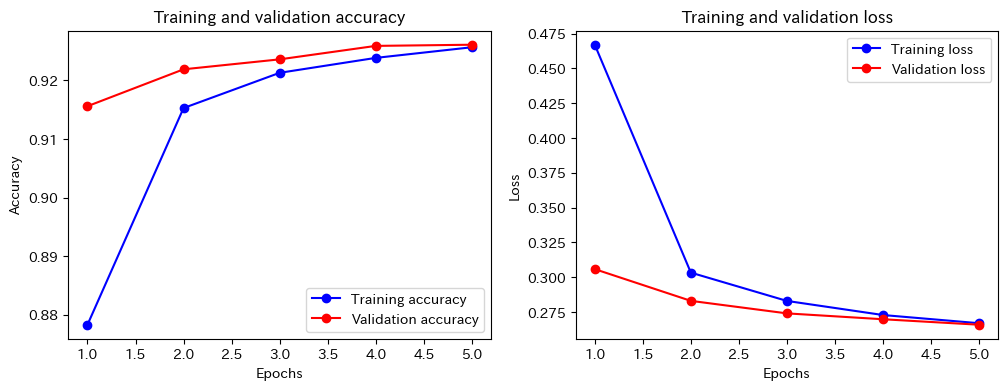

In [8]:
# コンパイルと学習を行う関数を定義
def compile_and_learn(model):
    # モデルをコンパイルする
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # モデルの学習
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)
    # 学習曲線の描画
    plot_learning_curve(history)
    return model

# コンパイルと学習を実行
compile_and_learn(model01)

### 混同行列（confusion matrix）を作成しよう

313/313 [==============================] - 1s 2ms/step


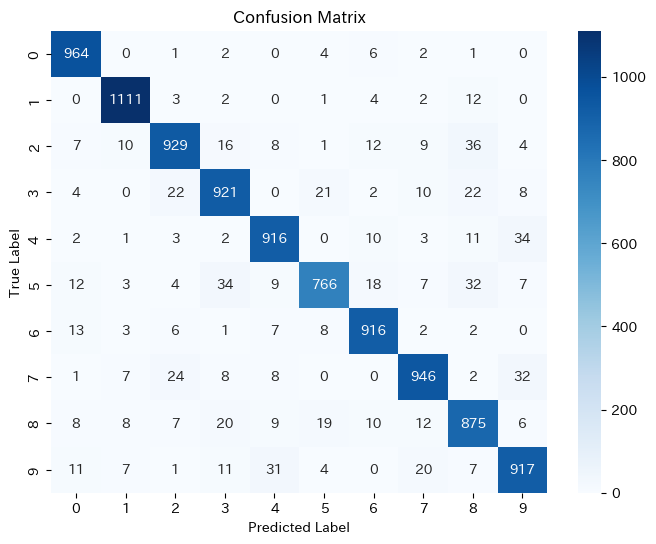

In [9]:
# 混同行列を描画する関数
def plot_confusion_matrix(model):
    # 検証用データに対する予測
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    # 混同行列の作成
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    # 混同行列の表示
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# コンパイルと学習を実行
plot_confusion_matrix(model01)

313/313 [==============================] - 0s 1ms/step


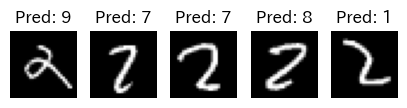

In [10]:
# @title ## 参考：誤分類した画像を確認してみよう
# 立体的に可視化してみよう
正解ラベル = "2" # @param [0,1,2,3,4,5,6,7,8,9]
表示数 = 5 #@param {type:"slider", min:5, max:20, step:1}

# 予測を誤ってしまった画像を表示する関数
def check_incorrect_predictions(model,label,numd):
    # 検証用データに対する予測
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    # 実際のラベルが`label`で与えられたものと等しく、かつ予測が間違っている画像のインデックスを取得
    incorrect_indices = np.where((y_test == label) & (y_pred_classes != label))[0]

    # 画像を表示する
    num_images_to_show = min(numd, len(incorrect_indices))  # 表示する画像の数を設定
    plt.figure(figsize=(numd, 2))
    for i, index in enumerate(incorrect_indices[:num_images_to_show]):
        plt.subplot(1, num_images_to_show, i + 1)
        plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
        plt.title(f"Pred: {y_pred_classes[index]}")
        plt.axis('off')
    plt.show()

# 実際のラベルに対して予測が間違っている画像を表示
check_incorrect_predictions(model01,int(正解ラベル),表示数)

## 中間層を追加したモデルを作ってみよう

Model: "model02"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               100480    
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


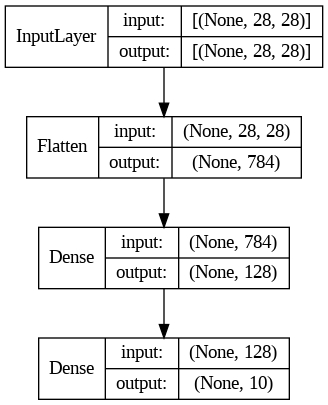

In [11]:
# モデルの定義
model02 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
],name='model02')

# モデルのサマリーを表示
model02.summary()

# モデルを可視化して画像を出力
plot_model(model02, to_file='model02.png', show_shapes=True, show_layer_names=False)
# 画像を表示
display(Image(filename='model02.png'))

### モデルのコンパイルと学習

Epoch 1/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2633 - accuracy: 0.9243 - val_loss: 0.1483 - val_accuracy: 0.9526
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1153 - accuracy: 0.9652 - val_loss: 0.1022 - val_accuracy: 0.9699
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0798 - accuracy: 0.9763 - val_loss: 0.1012 - val_accuracy: 0.9672
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0600 - accuracy: 0.9816 - val_loss: 0.0752 - val_accuracy: 0.9762
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0469 - accuracy: 0.9853 - val_loss: 0.0751 - val_accuracy: 0.9762


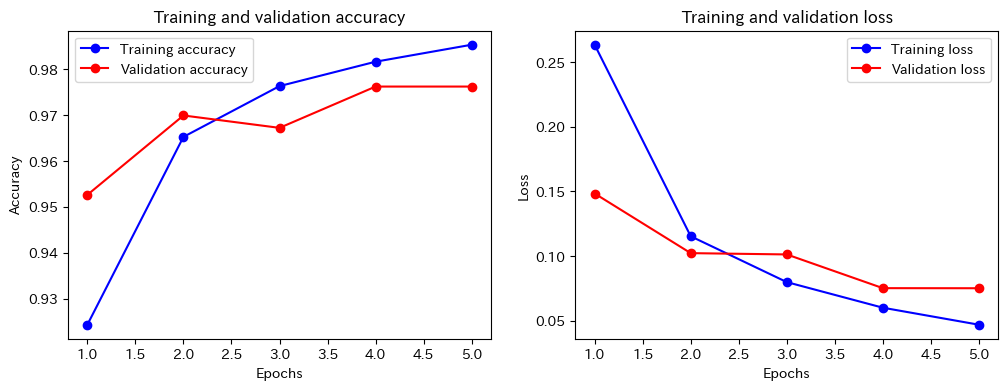

In [ ]:
# コンパイルと学習を実行
compile_and_learn(model02)

313/313 [==============================] - 1s 1ms/step


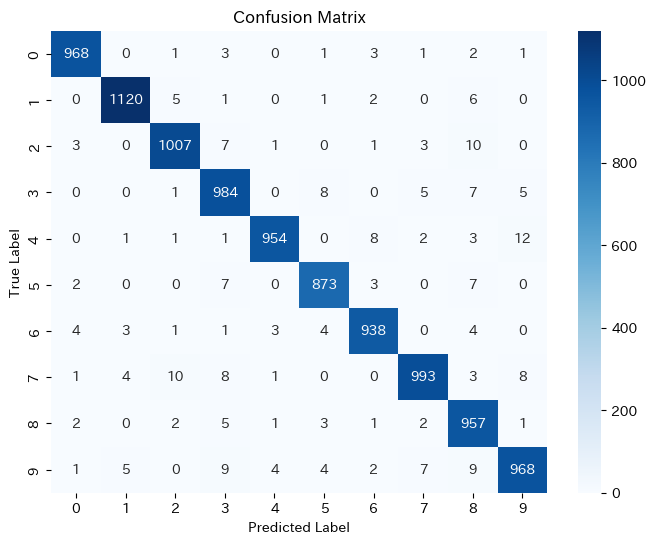

In [ ]:
# @title ## 参考：混同行列（confusion matrix）を作成しよう
plot_confusion_matrix(model02)

313/313 [==============================] - 0s 1ms/step


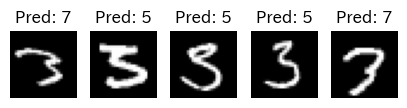

In [ ]:
# @title ## 参考：誤分類した画像を確認してみよう
# 立体的に可視化してみよう
正解ラベル = "3" # @param [0,1,2,3,4,5,6,7,8,9]
表示数 = 5 #@param {type:"slider", min:5, max:20, step:1}

# 実際のラベルに対して予測が間違っている画像を表示
check_incorrect_predictions(model02,int(正解ラベル),表示数)

## 高度なモデルを作ってみよう

Model: "model03"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 6)         30        
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        400       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 16)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 576)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               7385

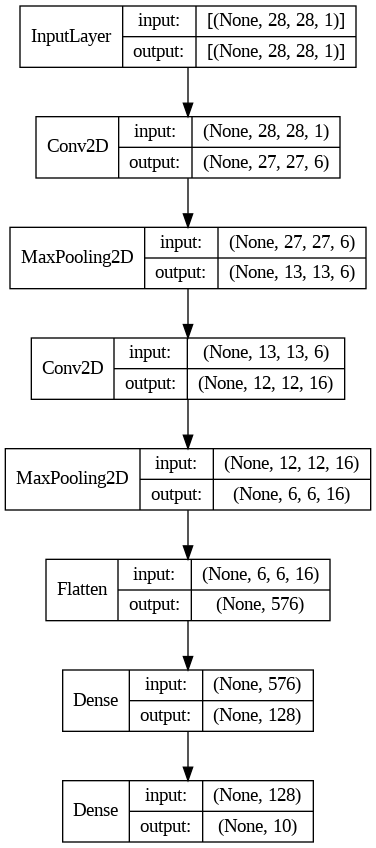

In [ ]:
# モデルの定義
model03 = Sequential([
    Conv2D(6, kernel_size=(2, 2), input_shape=(28, 28, 1), activation='ReLU'), #← 第一の畳み込み層
    MaxPooling2D(pool_size=(2, 2)), #← 第一の最大値プーリング層
    Conv2D(16, kernel_size=(2, 2), activation='ReLU'),#← 第二の畳み込み層
    MaxPooling2D(pool_size=(2, 2)),#← 第二の最大値プーリング層
    Flatten(),#← 全結合層
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
],name='model03')

# モデルのサマリーを表示
model03.summary()

# モデルを可視化して画像を出力
plot_model(model03, to_file='model03.png', show_shapes=True, show_layer_names=False)
# 画像を表示
display(Image(filename='model03.png'))

### モデルのコンパイルと学習

Epoch 1/5
1875/1875 [==============================] - 11s 5ms/step - loss: 0.2132 - accuracy: 0.9372 - val_loss: 0.0781 - val_accuracy: 0.9758
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0728 - accuracy: 0.9779 - val_loss: 0.0602 - val_accuracy: 0.9799
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0507 - accuracy: 0.9840 - val_loss: 0.0506 - val_accuracy: 0.9835
Epoch 4/5
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0379 - accuracy: 0.9879 - val_loss: 0.0455 - val_accuracy: 0.9853
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0304 - accuracy: 0.9904 - val_loss: 0.0390 - val_accuracy: 0.9873


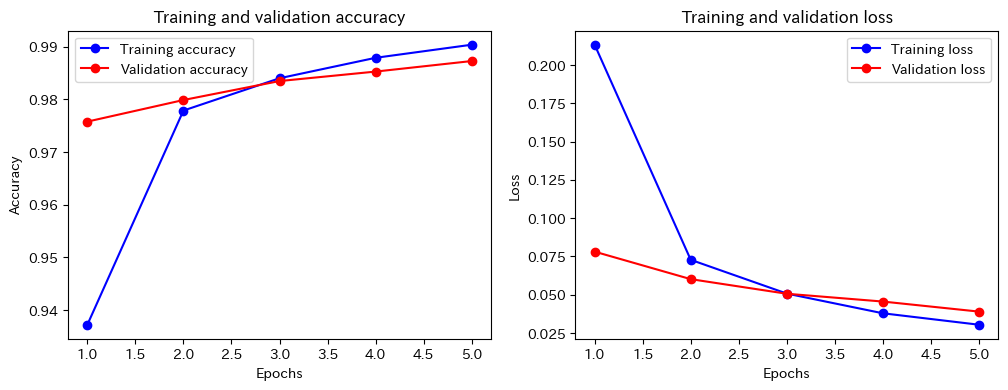

In [ ]:
# コンパイルと学習を実行
compile_and_learn(model03)

### 参考：混同行列（confusion matrix）を作成しよう

313/313 [==============================] - 1s 2ms/step


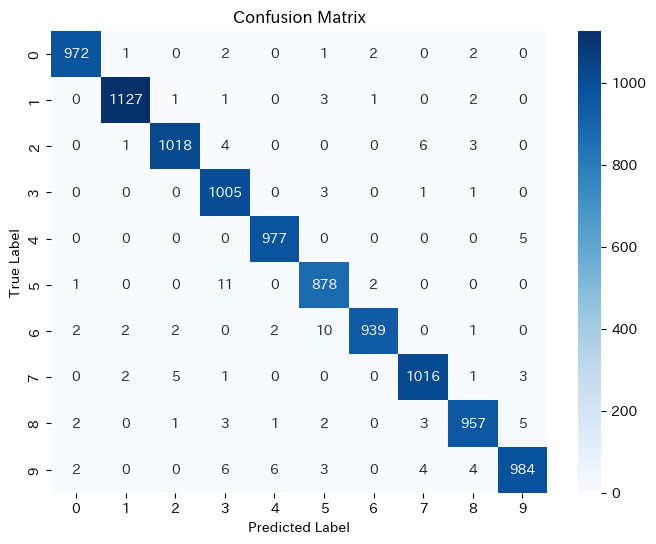

In [ ]:
plot_confusion_matrix(model03)

313/313 [==============================] - 1s 2ms/step


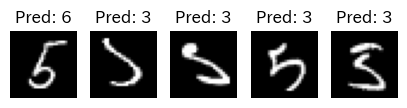

In [ ]:
# @title ## 参考：誤分類した画像を確認してみよう
# 立体的に可視化してみよう
正解ラベル = "5" # @param [0,1,2,3,4,5,6,7,8,9]
表示数 = 5 #@param {type:"slider", min:5, max:20, step:1}

# 実際のラベルに対して予測が間違っている画像を表示
check_incorrect_predictions(model03,int(正解ラベル),表示数)

In [ ]:
# @title ## 参考：GUIで手書き文字を認識しよう
!pip install gradio==4.29.0
import gradio as gr
import numpy as np

model_name = "model03"  # @param ["model01", "model02", "model03"]
if model_name == "model01":
    md = model01
elif model_name == "model02":
    md = model02
elif model_name == "model03":
    md = model03

# Function to resize and normalize the image
def reshape_to_28x28(image):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)  # Add channel dimension
    resized_image = tf.image.resize(image, [28, 28]).numpy()
    normalized_image = resized_image / 255.0  # Normalize the image to range [0, 1]
    return normalized_image

# Define the prediction function
def classify(sketch):
    image = sketch["composite"]
    grayscale_image = np.mean(image, axis=2)  # Average across RGB channels

    # Resize and normalize the image
    resized_image = reshape_to_28x28(grayscale_image)

    # Convert the image to the correct shape for the model
    reshaped_image = resized_image.reshape(1, 28, 28, 1)  # Add batch and channel dimensions

    # Make predictions and convert the result to a list
    pred = md.predict(reshaped_image).tolist()[0]

    # Get the top 3 predictions
    values, indices = tf.math.top_k(pred, k=3)
    values = values.numpy().tolist()
    indices = indices.numpy().tolist()

    # Store confidences in a dictionary
    confidences = {str(i): v for i, v in zip(indices, values)}

    return confidences

# Gradioインターフェースを作成
gr.Interface(
    fn=classify,
    inputs="sketchpad",
    outputs="label",
).launch(debug=True)

In [ ]:
'''
参考：このコードセルの内容を理解する必要はありません
'''
# @title ## 参考：評価用画像でモデルごとの精度を確認しよう
from PIL import Image as PILImage
import numpy as np

model_name = "model03"  # @param ["model01", "model02", "model03"]
if model_name == "model01":
    md = model01
elif model_name == "model02":
    md = model02
elif model_name == "model03":
    md = model03

# Function to resize and normalize the image
def reshape_to_28x28(image):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)
    resized_image = tf.image.resize(image, [28, 28]).numpy()
    normalized_image = resized_image / 255.0
    return normalized_image

# 推論用の関数
def predict_image(model, image_path, dsp=False):
    # 画像を読み込む
    image = PILImage.open(image_path)
    grayscale_image = np.mean(image, axis=2)

     # 画像をリサイズし、正規化する
    resized_image = reshape_to_28x28(grayscale_image)

    # モデル用に画像を正しい形状に変換する
    reshaped_image = resized_image.reshape(1, 28, 28, 1)

    # 予測を行い、結果をリストに変換する
    pred = md.predict(reshaped_image).tolist()[0]

    # 上位3つの予測を取得する
    values, indices = tf.math.top_k(pred, k=3)
    values = values.numpy().tolist()
    indices = indices.numpy().tolist()

    # 結果を表示
    if dsp:
        plt.imshow(resized_image, cmap='gray')
        plt.axis('off')
        plt.show()

    # トップ5の予測結果を出力
    results = []
    for v,i in zip(values, indices):
        # print(f"Label {i}: Probability {v:.4f}")
        results.append({
            'Label': i,
            'Probability': v
        })
    return pd.DataFrame(results)

# 評価用画像のダウンロード
!wget -O chap07_sample_digit_5.png https://raw.githubusercontent.com/coraldx5/generativeai_intro_book/master/chap07_sample_digit_5.png

# PNG画像のパス
image_path = 'chap07_sample_digit_5.png'

print("◆◆ 検証用画像 ◆◆")
# 推論を実行
res_df = predict_image(md, image_path, dsp=True)
res_df

In [ ]:
# @title ## 参考：モデルの可視化を行うコード
# ネットワーク構造を可視化するためのライブラリをインストールします
!pip install visualkeras==0.1.0
import visualkeras

# 立体的に可視化してみよう
model_name = "model03" # @param ["model01", "model02", "model03"]
if model_name=="model01":
    md=model01
elif model_name=="model02":
    md=model02
elif model_name=="model03":
    md=model03
visualkeras.layered_view(md, legend=True, show_dimension=True)